In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import parse_raw_to_csv
import os
import numpy as np
import seaborn as sns
import math

#Just use set_theme() function of seaborn library for a nice looking appearance.
sns.set_theme()

df = pd.DataFrame()

for i in range(1,31):
    df_tmp = parse_raw_to_csv.parse_file_or_folder("../../experiments/hpl_scaling/m%d.txt" % i, parse_raw_to_csv.parse_map.values())
    df_tmp["m"] = i
    df_tmp["type"] = "IEC"
    df = df.append(df_tmp)

for i in [30 + t*5 for t in range(1,8)]:
    df_tmp = parse_raw_to_csv.parse_file_or_folder("../../experiments/hpl_scaling/m%d.txt" % i, parse_raw_to_csv.parse_map.values())
    df_tmp["m"] = i
    df_tmp["type"] = "IEC"
    df = df.append(df_tmp)


df["benchmark"] = df.index
df = df.apply(pd.to_numeric, errors='ignore')
df = df.reset_index()
df

,index,version,size,device,error,resid,epsilon,total_best_time,total_avg_time,total_gflops,lu_best_time,lu_avg_time,lu_gflops,sl_best_time,sl_avg_time,sl_gflops,filename,m,benchmark
0,LINPACK,2.4,512,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.000095,0.000003,1.192090e-07,0.005487,0.005489,16.4032,0.005487,0.005489,16.3077,2.600000e-08,2.960000e-08,20164.9,../../experiments/hpl_scaling/m1.txt,1,LINPACK
1,LINPACK,2.4,1024,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.000043,0.000006,1.192090e-07,0.012734,0.012737,56.3763,0.012734,0.012737,56.2117,2.500000e-08,3.120000e-08,83886.1,../../experiments/hpl_scaling/m2.txt,2,LINPACK
2,LINPACK,2.4,1536,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.165809,0.048315,1.192090e-07,0.026556,0.026569,91.1534,0.026556,0.026569,90.9758,2.700000e-08,3.180000e-08,174763.0,../../experiments/hpl_scaling/m3.txt,3,LINPACK
3,LINPACK,2.4,2048,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.112348,0.057949,1.192090e-07,0.048618,0.048646,117.9600,0.048618,0.048646,117.7880,2.200000e-08,2.740000e-08,381300.0,../../experiments/hpl_scaling/m4.txt,4,LINPACK
4,LINPACK,2.4,2560,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.094789,0.075883,1.192090e-07,0.078691,0.078851,142.3020,0.078691,0.078851,142.1360,2.200000e-08,2.620000e-08,595782.0,../../experiments/hpl_scaling/m5.txt,5,LINPACK
5,LINPACK,2.4,3072,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.065928,0.076186,1.192090e-07,0.117660,0.117836,164.4250,0.117660,0.117836,164.2650,2.100000e-08,2.760000e-08,898779.0,../../experiments/hpl_scaling/m6.txt,6,LINPACK
6,LINPACK,2.4,3584,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.105130,0.164493,1.192090e-07,0.166343,0.166862,184.6590,0.166343,0.166862,184.5050,2.800000e-08,3.280000e-08,917504.0,../../experiments/hpl_scaling/m7.txt,7,LINPACK
7,LINPACK,2.4,4096,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.061354,0.125640,1.192090e-07,0.224123,0.224229,204.5590,0.224123,0.224229,204.4100,2.700000e-08,3.200000e-08,1242760.0,../../experiments/hpl_scaling/m8.txt,8,LINPACK
8,LINPACK,2.4,4608,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.039140,0.100980,1.192090e-07,0.288736,0.289818,226.0620,0.288736,0.289818,225.9150,2.800000e-08,3.520000e-08,1516690.0,../../experiments/hpl_scaling/m9.txt,9,LINPACK
9,LINPACK,2.4,5120,p520_max_sg280l : BittWare Stratix 10 OpenCL p...,0.032024,0.102124,1.192090e-07,0.362471,0.363509,247.0010,0.362471,0.363509,246.8570,2.700000e-08,3.080000e-08,1941810.0,../../experiments/hpl_scaling/m10.txt,10,LINPACK


In [4]:
b=512
g=8
f=270e6
f_c = 157e6
t_mm =  (((b ** 2)/(g*f)*3.5 + (b/g) ** 3 / f))
#       load and store block   forward rows and cols    update matrix
t_lu =  (b ** 2)/(g*f)*4 + sum(300/f + (b/g)/f_c + (b * (b - g * int(i/g)))/(g ** 2) / f for i in range(b))

def perf_last(m, torus_width=1, time=False, r=5):
    #LU time at the very beginning of the calculation and at the very end
    lu_total = t_lu + max(m - 2, 0) * t_lu
    def lu_runtime(i):
        return t_lu + max(math.ceil(i/torus_width) - 2,0) * t_lu  #+ max(math.ceil(i/torus_width) - 2,0) * (torus_width * 150*b + 700*b)/f
    def mm_runtime(i):
        remaining_blocks = i/torus_width
        return ((remaining_blocks ** 2) / r) * t_mm
    main_calc_time = sum(max(((2 * (i /torus_width) - 1) / r) * t_mm + lu_runtime(i), mm_runtime(i))  for i in range(1,m * torus_width))
    exe_time = lu_total + main_calc_time
    gflops = (2*((m*torus_width*512) ** 3)/3)/ exe_time * 1.0e-9
    if time:
        return exe_time
    else:
        return gflops

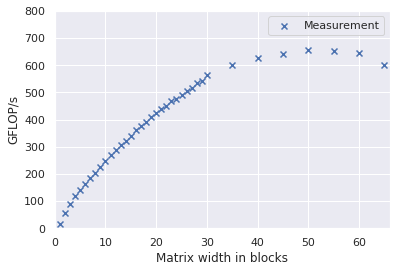

In [6]:
fig, hpl = plt.subplots(1)
hpl.scatter(df["m"], df["lu_gflops"], label="Measurement", marker="x")
#hpl.plot(list(range(66)), [perf_last(m) for m in range(66)], label="Model")
#hpl.plot(np.linspace(0,66), [(2* 512 ** 3)/(((b ** 2)/(g*f)*2 + (b/g) ** 3 / f)) * 1.0e-9 * 5 for m in np.linspace(0,66)], label="Model", linestyle="--")
#hpl.plot(np.linspace(0,66), [(2* 512 ** 3)/(((b ** 2)/(g*f)*4 + (b/g) ** 3 / f))* 1.0e-9 * 5 for m in np.linspace(0,66)], label="Matrix Multiplication", linestyle="--")
#hpl.annotate("%.1f GFLOP/s" % ((2* 512 ** 3)/(((b ** 2)/(g*f)*2 + (b/g) ** 3 / f)) * 1.0e-9 * 5), (1,(2* 512 ** 3)/(((b ** 2)/(g*f)*2 + (b/g) ** 3 / f)) * 1.0e-9 * 5 + 20))
#hpl.annotate("%.1f GFLOP/s" % ((2* 512 ** 3)/(((b ** 2)/(g*f)*4 + (b/g) ** 3 / f)) * 1.0e-9 * 5), (1,(2* 512 ** 3)/(((b ** 2)/(g*f)*4 + (b/g) ** 3 / f)) * 1.0e-9 * 5 + 20))
hpl.set_xlabel("Matrix width in blocks")
hpl.set_ylabel("GFLOP/s")
hpl.set_xlim((0,66))
hpl.set_ylim((0,800))
hpl.legend()
fig.savefig("hpl_scaling.pdf")

In [ ]:
50000/f

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import parse_raw_to_csv_novalidate
import os
import numpy as np

df = pd.DataFrame()

for i in range(40,56):
    df_tmp = parse_raw_to_csv_novalidate.parse_file_or_folder("../experiments/hpl_scaling/m%d_sq_large.txt" % i, parse_raw_to_csv_novalidate.parse_map.values())
    df_tmp["m"] = i
    df = df.append(df_tmp)

df["benchmark"] = df.index
df = df.apply(pd.to_numeric, errors='ignore')
df = df.reset_index()
df

In [ ]:
fig, hpl = plt.subplots(1)
hpl.plot(df["m"], df["lu_gflops"])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import parse_raw_to_csv_novalidate
import os
import numpy as np

df = pd.DataFrame()

for i in [20 + t*5 for t in range(1,11)]:
    df_tmp = parse_raw_to_csv_novalidate.parse_file_or_folder("../experiments/hpl_scaling/m%d_sq.txt" % i, parse_raw_to_csv_novalidate.parse_map.values())
    df_tmp["m"] = i
    df = df.append(df_tmp)

df["benchmark"] = df.index
df = df.apply(pd.to_numeric, errors='ignore')
df = df.reset_index()
df

In [ ]:
fig, hpl = plt.subplots(1)
hpl.plot(df["m"], df["lu_gflops"])
hpl.plot(range(71), [perf(m) for m in range(71)])
hpl.set_ylim(0,1200)